# Intro

We'll need to predict relevance between paragraph and question pair. 
In input we have some paragraphs, question and (for train set) paragraph-question relevance. Also, in test set we'll see some generated qquestions.

In [1]:
%matplotlib inline

from functools import lru_cache
from itertools import chain

from IPython.display import clear_output, display
from ipywidgets import IntProgress
from gensim.models import Word2Vec
from Levenshtein import distance
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import numpy as np
import pandas as pd
import pickle as pkl
from pymorphy2 import MorphAnalyzer
import re
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

C:\Users\alex\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
dftrain = pd.read_csv("train_task1_latest.csv")
dftrain.head(10)

,paragraph_id,question_id,paragraph,question,target
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0
5,3559,62585,Белки — высокомолекулярные органические вещест...,Какие действия предприняла подводная лодка Чер...,0.0
6,4350,3730,Прайсинговые методы — в основе лежит принцип и...,"Как называют остановки, до которых и на которы...",0.0
7,8012,86629,Применяли изначально для определения близкород...,Какой признак киевский монах Нестор-летописец ...,1.0
8,3634,69421,Успешная конверсия по-разному определяется гру...,"Чтобы понять, по какому рекламному каналу приш...",1.0
9,4350,27335,Прайсинговые методы — в основе лежит принцип и...,Урожайность сои в каких странах почти не отлич...,0.0


In [3]:
dftest = pd.read_csv("sdsj_A_test.csv")
dftest.head(10)

,paragraph_id,question_id,paragraph,question
0,1361,6463,"Передний мозг сильно развит, это самая большая...",В какой мифологии два ворона Хугин и Мунин шеп...
1,1403,34696,Мирмекологи исследуют муравьёв как в лаборатор...,Когда инсайдер покупает или гипотезы чего эвол...
2,1435,13751,Волновая: свет представляет собой волну в неви...,"Какие предположения, по мнению Ньютона, допуст..."
3,341,38544,Живые организмы подчиняются началам термодинам...,В каких условиях метаболизм поддерживает поряд...
4,1317,14589,Файлы нелатинского текста в Юникоде всегда зан...,Каким мелодиям Прокофьева особенно не укладыва...
5,412,26912,"Впоследствии, на основе анархо-панка было сфор...",Какая песня стала гимном панк-движения?
6,1282,18076,После этого из цифровых базовых матричных крис...,Каким методом модель ЦП доводится до ума?
7,689,19755,Хозяевами паразитических грибов чаще всего явл...,При какой рекомбинации у высших грибов диплоид...
8,1455,36313,Аморальное деяние может обрести статус преступ...,Когда деяние совершается в соответствующую уго...
9,432,12545,"Трудно определить, какой язык программирования...",Где может исполняться программа на языке треть...


Let's check class balance (seems like we'll have imbalance):

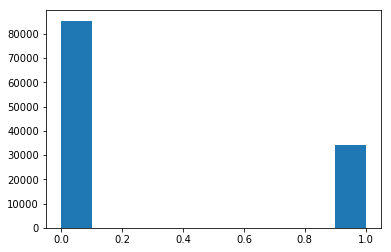

In [4]:
plt.hist(dftrain["target"]);

# Dummy model

In [5]:
def cv(estimator, X, y, question_ids, paragraph_ids, target_class):
    # It works next way:
    #  to avoid overfitting for paragraph/question:
    #    split paragraphs to few train/test sets (by id)
    #    split questions to few train/test sets (by id)
    #  for each paragraph/question sets pair:
    #    get record with given paragraph anf question
    #    train classifier of train subset
    #    classify test set, store score
    #  return mean score and standart deviation
    X_np = np.array(X)
    y_np = np.array(y)
    
    question_ids_unique_np = np.array(sorted(list(question_ids.unique())))
    paragraph_ids_unique_np = np.array(sorted(list(paragraph_ids.unique())))
    
    initial = estimator.get_params()
    
    n_splits_sqr = 3
    paragraph_kfold = KFold(n_splits=n_splits_sqr)
    question_kfold = KFold(n_splits=n_splits_sqr)
    
    pb = IntProgress(min=0, max=n_splits_sqr * n_splits_sqr, value=0)
    display(pb)
        
    scores = []
    
    for paragraph_train_index, paragraph_test_index in paragraph_kfold.split(paragraph_ids_unique_np):
        paragraph_idx_train = np.isin(paragraph_ids, paragraph_ids_unique_np[paragraph_train_index])
        paragraph_idx_test = np.isin(paragraph_ids, paragraph_ids_unique_np[paragraph_test_index])
        
        for question_train_index, question_test_index in question_kfold.split(question_ids_unique_np):
            question_idx_train = np.isin(question_ids, question_ids_unique_np[question_train_index])
            question_idx_test = np.isin(question_ids, question_ids_unique_np[question_test_index])
            
            idx_train = np.logical_and(question_idx_train, paragraph_idx_train)
            idx_test = np.logical_and(question_idx_test, paragraph_idx_test)
            
            X_train = X_np[idx_train]
            y_train = y_np[idx_train]
            X_test = X_np[idx_test]
            y_test = y_np[idx_test]
            
            estimator.set_params(**initial)
            estimator.fit(X_train, y_train)
            
            target_class_index = estimator.classes_.tolist().index(target_class)
            prediction = estimator.predict_proba(X_test)[:, target_class_index]
            score = roc_auc_score(y_test, prediction)
            scores.append(score)
            
            pb.value += 1
    scores_np = np.array(scores)
    return scores_np.mean(), scores_np.std()

In [7]:
print(np.__version__)
cv(DummyClassifier(),
   np.zeros([len(dftrain), 1]),
   dftrain["target"],
   dftrain["paragraph_id"],
   dftrain["question_id"],
   1)

1.12.1


AttributeError: module 'numpy' has no attribute 'isin'

# Text preparations

I'll use next conversions:
- split paragraph to individual sentences (in some cases question have most relevant sentences)
- lemmatize sentences
- concatenate lemmatized sentences (so I'll have lemmatized paragraph)

In [9]:
def split_paragraph(df):
    def _split_sentences(text):
        return list(filter(lambda sentence: sentence != "", 
                           map(lambda sentence: sentence.strip(), 
                               re.split("[.!?]", text))))
    
    df["paragraph_sentences"] = [_split_sentences(paragraph)
                                 for paragraph in tqdm(df["paragraph"])]
    return df

In [10]:
dftrain = split_paragraph(dftrain)
dftest = split_paragraph(dftest)

100%|█████████████████████████████████████████████████████████████████████████| 74286/74286 [00:02<00:00, 30839.34it/s]


In [11]:
morph = MorphAnalyzer()


@lru_cache(2000000)
def _lemmatize_word(word):
    return morph.parse(word)[0].normal_form


stop_morphs = [_lemmatize_word(word) for word in stopwords.words('russian')]


@lru_cache(200000)
def _lemmatize_text(text):
    words = filter(lambda token: re.match("\w+", token),
                   wordpunct_tokenize(text.lower()))
    return " ".join(map(_lemmatize_word, words))


def lemmatize_question(df):
    df["question_lemmatized"] = [_lemmatize_text(question)
                                 for question in tqdm(df["question"])]
    return df


def lemmatize_paragraph_sentences(df):
    df["paragraph_sentences_lemmatized"] = [[_lemmatize_text(sentence) for sentence in sentences]
                                            for sentences in tqdm(df["paragraph_sentences"])]
    return df

In [12]:
dftrain = lemmatize_question(lemmatize_paragraph_sentences(dftrain))
dftest = lemmatize_question(lemmatize_paragraph_sentences(dftest))

100%|█████████████████████████████████████████████████████████████████████████| 74286/74286 [00:07<00:00, 10292.60it/s]


In [13]:
def lemmatize_paragraph(df):
    df["paragraph_lemmatized"] = [" ".join(sentences)
                                  for sentences in tqdm(df["paragraph_sentences_lemmatized"])]
    return df

In [14]:
dftrain = lemmatize_paragraph(dftrain)
dftest = lemmatize_paragraph(dftest)

100%|████████████████████████████████████████████████████████████████████████| 74286/74286 [00:00<00:00, 250512.21it/s]


# Preparations:

There I'll:
- calculate IDF on train set words (for lemmatized texts)
- train word2vec on lemmatized texts (mayeb it'll be better to use pretrained model from https://nlpub.ru/Russian_Distributional_Thesaurus)

In [15]:
def calculate_idfs(df):
    def _get_unique_texts(df):
        return set(df["paragraph_lemmatized"].unique()) | set(df["question_lemmatized"].unique())
    
    texts = _get_unique_texts(df)
    vectorizer = CountVectorizer()
    counts = np.asarray(vectorizer.fit_transform(texts).sum(axis=0))[0]
    counts_inv = np.divide(np.ones(counts.shape), counts)
    idf_values = np.log(counts_inv)
    return {
        word: idf
        for word, idf in zip(vectorizer.get_feature_names(), idf_values)
    }

In [16]:
idfs = calculate_idfs(dftrain)

In [17]:
def train_word2vec(df):
    sentences = list(df["paragraph_lemmatized"]) + list(df["question"])
    return Word2Vec(sentences)

In [18]:
word2vec = train_word2vec(dftrain)

# Baseline (question to paragraph sentence intersections)

Let's define sentence-to-question intersection operation next way:
- it get's 2 lemmatized texts
- for each word1, word2 pair (where word1 in text1, word2 in text2 and word1, word2 not in stop words):
  - it get's cosine similarity of word2vec vector
  - if similarity > threshold - it store word pair in set
- it's return builded set

In [19]:
def intersection_generator(word2vec, threshold, stopwords):
    def intersection(text1, text2):
        words1 = set(text1.split(' '))
        words2 = set(text2.split(' '))
        result = set()
        for word1 in words1:
            if word1 in stopwords:
                continue
            for word2 in words2:
                if word2 in stopwords:
                    continue
                if word1 == word2:
                    similarity = 1.0
                elif word1 in word2vec and word2 in word2vec:
                    similarity = word2vec.similarity(word1, word2)
                else:
                    similarity = 0.0
                if similarity >= threshold:
                    result.add(word1 + ":" + word2)
        return [words.split(':')[:2] for words in result]
    return intersection

In [20]:
word2vec_intersection = intersection_generator(word2vec, 0.8, stop_morphs)

Now let's check this intersection on few paragraph/question pairs:

In [29]:
intersection = [len(word2vec_intersection(sentence, dftrain["question_lemmatized"][0]))
                for sentence in dftrain["paragraph_sentences_lemmatized"][0]]
print(list(intersection), dftrain.loc[0, "target"])

[0, 0, 0, 0] 0.0


In [30]:
intersection = [len(word2vec_intersection(sentence, dftrain["question_lemmatized"][1]))
                for sentence in dftrain["paragraph_sentences_lemmatized"][1]]
print(list(intersection), dftrain.loc[1, "target"])

[0, 0, 0, 0, 0, 0, 0] 0.0


In [31]:
intersection = [len(word2vec_intersection(sentence, dftrain["question_lemmatized"][7]))
                for sentence in dftrain["paragraph_sentences_lemmatized"][7]]
print(list(intersection), dftrain.loc[7, "target"])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0] 1.0


In [32]:
intersection = [len(word2vec_intersection(sentence, dftrain["question_lemmatized"][8]))
                for sentence in dftrain["paragraph_sentences_lemmatized"][8]]
print(list(intersection), dftrain.loc[8, "target"])

[0, 0, 0, 1, 10] 1.0


In [33]:
del intersection

Let's define paragraph-to-question intersection function next way:
- it's get paragraph sentences, question and sentence-to-question intersection function
- for each sentence:
  - get intersection (as pairs of sentence and question words)
  - store intersection word pairs in set
  - store intersection size in list
- return total intersection words set and sentence intersection sizes (as numpy array)

In [34]:
def paragraph_sentences_question_intersection(paragraph_sentences, question, intersection_function):
    intersection = set()
    intersection_sizes = []
    for paragraph_sentence in paragraph_sentences:
        sentence_intersection = intersection_function(paragraph_sentence, question)
        intersection_sizes.append(len(sentence_intersection))
        for isect in sentence_intersection:
            word1, word2 = isect[:2]
            intersection.add(word1 + ":" + word2)
    return [pair.split(":") for pair in intersection], np.array(intersection_sizes)

In [35]:
paragraph_sentences_question_intersection(dftrain["paragraph_sentences_lemmatized"][0],
                                          dftrain["question_lemmatized"][0],
                                          word2vec_intersection)

([], array([0, 0, 0, 0]))

In [36]:
paragraph_sentences_question_intersection(dftrain["paragraph_sentences_lemmatized"][1],
                                          dftrain["question_lemmatized"][1],
                                          word2vec_intersection)

([], array([0, 0, 0, 0, 0, 0, 0]))

In [37]:
paragraph_sentences_question_intersection(dftrain["paragraph_sentences_lemmatized"][7],
                                          dftrain["question_lemmatized"][7],
                                          word2vec_intersection)

([['монах', 'монах'],
  ['использовать', 'использовать'],
  ['признак', 'признак'],
  ['летописец', 'летописец'],
  ['киевский', 'киевский'],
  ['нестор', 'нестор']],
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0]))

In [38]:
paragraph_sentences_question_intersection(dftrain["paragraph_sentences_lemmatized"][8],
                                          dftrain["question_lemmatized"][8],
                                          word2vec_intersection)

([['рекламный', 'рекламный'],
  ['понять', 'понять'],
  ['канал', 'канал'],
  ['сайт', 'сайт'],
  ['сбор', 'сбор'],
  ['подключаться', 'подключаться'],
  ['точный', 'точный'],
  ['клиент', 'клиент'],
  ['информация', 'информация'],
  ['прийти', 'прийти']],
 array([ 0,  0,  0,  1, 10]))

Let's store intersection and intersection sizes in dataset:

In [39]:
def sentences_intersection(df, intersection_function):
    intersection_params = [paragraph_sentences_question_intersection(df.loc[i, "paragraph_sentences_lemmatized"],
                                                                     df.loc[i, "question_lemmatized"],
                                                                     intersection_function)
                           for i in tqdm(range(len(df)))]
    intersections = [row[0] for row in intersection_params]
    intersection_sizes = [row[1] for row in intersection_params]
    df["intersections"] = intersections
    df["intersection_sizes"] = intersection_sizes
    return df

In [40]:
dftrain = sentences_intersection(dftrain, word2vec_intersection)
dftest = sentences_intersection(dftest, word2vec_intersection)

100%|███████████████████████████████████████████████████████████████████████████| 74286/74286 [05:57<00:00, 207.92it/s]


Let's calculate next features:
- paragraph/question intersection length (count of word pairs in intersection)
- paragraph/question intersection IDF (sum of intersection word pair's IDF)
- on intersection size per individual paragraph sentences:
  - divide to question word count:
    - get mean value
    - get standart deviation
  - divide to sentence word count:
    - get mean value
    - get standart deviation

In [41]:
def sentence_intersection_features(df, intersection_function, idfs):
    def _mean(val):
        if len(val.ravel()) == 0:
            return 0.0
        else:
            return val.mean()
        
    features = np.zeros([len(df), 6])
    names = ['sentence_intersection_sizes', 'sentence_intersection_idf', 
             'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
             'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question']
    for i in tqdm(range(0, len(df))):
        intersection = df.loc[i, "intersections"]
        intersection_sizes = df.loc[i, "intersection_sizes"]
        intersection_idf = np.array([idfs.get(word1, 0) * idfs.get(word2, 0)
                                               for word1, word2 in intersection]).sum()
        intersection_sizes_to_question = intersection_sizes / len(df.loc[i, "question_lemmatized"].split(" "))
        intersection_sizes_to_paragraph = np.divide(intersection_sizes,
                                                    np.array([len(sentence.split(" "))
                                                              for sentence in df.loc[i, "paragraph_sentences_lemmatized"]]))
        features[i, 0] = len(intersection)
        features[i, 1] = intersection_idf.sum()
        features[i, 2] = _mean(intersection_sizes_to_paragraph)
        features[i, 3] = _mean(intersection_sizes_to_question)
        features[i, 4] = intersection_sizes_to_paragraph.std()
        features[i, 5] = intersection_sizes_to_question.std()
    for i, name in enumerate(names):
        df[name] = features[:, i]
    return df

In [42]:
dftrain = sentence_intersection_features(dftrain, word2vec_intersection, idfs)
dftest = sentence_intersection_features(dftest, word2vec_intersection, idfs)

100%|██████████████████████████████████████████████████████████████████████████| 74286/74286 [00:27<00:00, 2668.55it/s]


In [43]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question']
cv(XGBClassifier(),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99225030712313389, 0.0011922117701041418)

# Whole paragraph intersection

Let's calculate intersections per whole paragraph (by intersection with concatenated sentences) and store next features:
- intersection length (word pair count)
- question length (word count)
- paragraph length (word count)
- paragraph IDF
- question IDF
- intersection IDF

In [44]:
def paragraph_intersection_features(df, intersection_func, idfs):
    features = np.zeros([len(df), 6])
    names = ['len_paragraph', 'len_question', 'len_intersection',
             'idf_paragraph', 'idf_question', 'idf_intersection']
    for i in tqdm(range(len(df))):
        row = df.loc[i]
        paragraph_words = set(row["paragraph_lemmatized"].split(' '))
        question_words = set(row["question_lemmatized"].split(' '))
        intersection = intersection_func(" ".join(paragraph_words), " ".join(question_words))
        intersection_flat = list(chain(*intersection))
        features[i, 0] = len(paragraph_words)
        features[i, 1] = len(question_words)
        features[i, 2] = len(intersection)
        features[i, 3] = np.sum([idfs.get(word, 0) for word in paragraph_words])
        features[i, 4] = np.sum([idfs.get(word, 0) for word in question_words])
        features[i, 5] = np.sum([idfs.get(word, 0) for word in intersection_flat])
    for i, name in enumerate(names):
        df[name] = features[:, i]
    return df

In [45]:
dftrain = paragraph_intersection_features(dftrain, word2vec_intersection, idfs)
dftest = paragraph_intersection_features(dftest, word2vec_intersection, idfs)

100%|███████████████████████████████████████████████████████████████████████████| 74286/74286 [04:44<00:00, 261.50it/s]


In [46]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'len_paragraph', 'len_question', 'len_intersection',
           'idf_question', 'idf_paragraph', 'idf_intersection']
cv(XGBClassifier(),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99486971830848014, 0.00091789539933222154)

# Question-paragraph distances

Let's define text "distances" next way (based on WMD):
- get 2 texts
- for each word of text1 - get most similar word from text 2 (by cosine distance between word2vec vectors) and store their similarity
- get mean similarity value (as "distance") and similarities standart deviation

And now let's calculate this distances and deviations between question and paragraph.

In [48]:
def _pair_distance(question, paragraph, word2vec):
    def _text_vectors(text):
        result = np.array([word2vec[word]
                           for word in text
                           if word in word2vec])
        if len(result) == 0:
            return np.ones([1, word2vec.vector_size]) * 0.01
        return result
    
    question_vectors = _text_vectors(question)
    paragraph_vectors = _text_vectors(paragraph)
    distances = cosine_distances(question_vectors, paragraph_vectors)
    word_min_distances = np.zeros([len(question_vectors)])
    for i in range(0, len(question_vectors)):
        word_min_distances[i] = distances[i, :].min()
    return word_min_distances.mean(), word_min_distances.std()


def pairs_distances(df, word2vec):
    questions = df["question_lemmatized"]
    paragraphs = df["paragraph_lemmatized"]
    features = np.zeros([len(questions), 2])
    names = ["distance_mean", "distance_std"]
    for i in tqdm(range(0, len(paragraphs))):
        features[i, :] = _pair_distance(questions[i], paragraphs[i], word2vec)
    for i, name in enumerate(names):
        df[name] = features[:, i]
    return df

In [49]:
dftrain = pairs_distances(dftrain, word2vec)
dftest = pairs_distances(dftest, word2vec)

100%|████████████████████████████████████████████████████████████████████████████| 74286/74286 [13:20<00:00, 92.82it/s]


In [50]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'len_paragraph', 'len_question', 'len_intersection',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'distance_mean', 'distance_std']
cv(XGBClassifier(),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99496936054557006, 0.0008919097663535084)

Now let's calculate same distances between question and paragraph sentences and store:
- mean distance
- distance deviation
- minimal distance

In [51]:
def sentence_pairs_distances(df, word2vec):
    questions = df["question_lemmatized"]
    paragraphs = df["paragraph_sentences_lemmatized"]
    features = np.zeros([len(questions), 3])
    names = ["sentence_distance_mean", "sentence_distance_std", "sentence_distance_min"]
    for i in tqdm(range(0, len(df))):
        distances = []
        for sentence in paragraphs[i]:
            distance = _pair_distance(questions[i], sentence, word2vec)
            distances.append(distance)
        distances = np.array(distances)
        features[i, 0] = distances.mean()
        features[i, 1] = distances.std()
        features[i, 2] = distances.min()
    for i, name in enumerate(names):
        df[name] = features[:, i]
    return df

In [53]:
dftrain = sentence_pairs_distances(dftrain, word2vec)
dftest = sentence_pairs_distances(dftest, word2vec)

100%|████████████████████████████████████████████████████████████████████████████| 74286/74286 [24:49<00:00, 37.59it/s]


In [54]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'len_paragraph', 'len_question', 'len_intersection',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'distance_mean', 'distance_std',
           'sentence_distance_mean', 'sentence_distance_std', 'sentence_distance_min']
cv(XGBClassifier(),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99497564783990333, 0.00083852999428613267)

In [74]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'len_paragraph', 'len_question', 'len_intersection',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'distance_mean', 'distance_std',
           'sentence_distance_min']
cv(XGBClassifier(),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99498953610968521, 0.00090323832211273059)

In [75]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'len_paragraph', 'len_question', 'len_intersection',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'distance_mean', 'distance_std',
           'sentence_distance_min']
cv(XGBClassifier(n_estimators=350),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99544184122644708, 0.00082143139051064071)

# Levenshtein distance-based features

Let's add features based on parargraph/question and paragraph sentence/question levenshtein distance

In [79]:
def levenshtein_features(df):
    features = np.zeros([len(df), 4])
    names = ['levenshtein_to_question', 'levenshtein_to_paragraph',
             'levenshtein_sentence_to_question', 'levenshtein_sentence_to_paragraph']
    for i in tqdm(range(len(df))):
        row = df.loc[i]
        question = df.loc[i, "question_lemmatized"]
        paragraph = df.loc[i, "paragraph_lemmatized"]
        sentences = df.loc[i, "paragraph_sentences_lemmatized"]
        question_paragraph_distance = distance(question, paragraph)
        features[i, 0] = question_paragraph_distance / len(question)
        features[i, 1] = question_paragraph_distance / len(paragraph)
        sentence_distances = []
        for sentence in sentences:
            sentence_distances.append(distance(question, sentence))
        sentence_distances_np = np.array(sentence_distances)
        features[i, 2] = sentence_distances_np.min() / len(question)
        features[i, 3] = sentence_distances_np.min() / len(sentences[sentence_distances_np.argmin()])
    for i, name in enumerate(names):
        df[name] = features[:, i]
    return df

In [80]:
dftrain = levenshtein_features(dftrain)
dftest = levenshtein_features(dftest)

100%|██████████████████████████████████████████████████████████████████████████| 74286/74286 [01:02<00:00, 1188.42it/s]


In [84]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'len_paragraph', 'len_question', 'len_intersection', 
           'distance_mean', 'distance_std',
           'sentence_distance_min',
           'levenshtein_to_question', 'levenshtein_to_paragraph',
           'levenshtein_sentence_to_question', 'levenshtein_sentence_to_paragraph']
cv(XGBClassifier(n_estimators=350),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99547023879010821, 0.00078842240781404577)

# Autogenerated question detection

## Uppercase characters

Also, automatically generated questions always have only first uppercase character. Let's add 2 features:

In [82]:
def _uppercase_count(text):
    if len(text) == 0:
        return 0
    count = 0
    for chr1, chr2 in zip(text, text.upper()):
        if chr1 == chr2:
            count += 1
    return count


def _question_uppercase_count(df):
    df["question_uppercase_count"] = [_uppercase_count(question) for question in tqdm(df["question"])]
    return df


def _question_uppercase_part(df):
    df["question_uppercase_part"] = np.divide(df["question_uppercase_count"],
                                              np.array([len(question) for question in df["question"]]))
    return df

def question_uppercase_features(df):
    return _question_uppercase_part(_question_uppercase_count(df))

In [83]:
dftrain = question_uppercase_features(dftrain)
dftest = question_uppercase_features(dftest)

100%|█████████████████████████████████████████████████████████████████████████| 74286/74286 [00:01<00:00, 37828.63it/s]


In [85]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'len_paragraph', 'len_question', 'len_intersection', 
           'distance_mean', 'distance_std',
           'question_uppercase_count', 'question_uppercase_part',
           'sentence_distance_min',
           'levenshtein_to_question', 'levenshtein_to_paragraph',
           'levenshtein_sentence_to_question', 'levenshtein_sentence_to_paragraph']
cv(XGBClassifier(n_estimators=350),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99558758426162874, 0.00080686351893124487)

## POS tags

Also let's add POS tag features (seems like automaticaally generated texts have different POS didtribution):

In [92]:
@lru_cache(2000000)
def _pos(word):
    return morph.parse(word)[0].tag.POS


def _pos_text(text):
    tags = list(filter(lambda pos_tag: pos_tag is not None,
                       map(_pos, wordpunct_tokenize(text))))
    result = {}
    for tag in tags:
        result[tag] = result.get(tag, 0) + 1
    result_scaled = {}
    for tag, count in result.items():
        result_scaled[tag] = count / len(tags)
    return result_scaled

def pos_questions(df):
    values = [_pos_text(question) for question in tqdm(df["question"])]
    tags = sorted(list(set(chain(*map(lambda value: list(value.keys()), values)))))
    for tag in tqdm(tags):
        df[tag + "_count"] = [row.get(tag, 0) for row in values]
    return df

In [93]:
dftrain = pos_questions(dftrain)
dftest = pos_questions(dftest)


 69%|██████████████████████████████████████████████████▏                      | 82161/119398 [00:13<00:06, 6072.95it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  3.70it/s]

 54%|████████████████████████████████████████▏                                 | 40385/74286 [00:12<00:23, 1440.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  4.89it/s]


In [94]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'len_paragraph', 'len_question', 
           'distance_std',
           'question_uppercase_count', 'question_uppercase_part',
           'sentence_distance_min',
           'levenshtein_to_paragraph', 'levenshtein_sentence_to_question', 'levenshtein_sentence_to_paragraph',
           'distance_mean', 'levenshtein_to_question',
           'ADJF_count', 'ADJS_count', 'ADVB_count', 'COMP_count',
           'CONJ_count', 'GRND_count', 'INFN_count', 'INTJ_count',
           'NOUN_count', 'NPRO_count', 'NUMR_count', 'PRCL_count',
           'PRED_count', 'PREP_count', 'PRTF_count', 'PRTS_count',
           'VERB_count']
cv(XGBClassifier(n_estimators=350),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99584127476529949, 0.00073714356968668682)

In [99]:
tag_columns = ['ADJF_count', 'ADJS_count', 'ADVB_count', 'COMP_count',
               'CONJ_count', 'GRND_count', 'INFN_count', 'INTJ_count',
               'NOUN_count', 'NPRO_count', 'NUMR_count', 'PRCL_count',
               'PRED_count', 'PREP_count', 'PRTF_count', 'PRTS_count',
               'VERB_count']
svm = OneClassSVM(verbose=True)
svm.fit(np.array(dftrain[tag_columns]))

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=True)

In [100]:
dftrain['pos_svm'] = svm.predict(np.array(dftrain[tag_columns]))
dftest['pos_svm'] = svm.predict(np.array(dftest[tag_columns]))

In [101]:
columns = ['sentence_intersection_sizes', 'sentence_intersection_idf',
           'sentence_intersection_mean_to_paragraph', 'sentence_intersection_mean_to_question',
           'sentence_intersection_std_to_paragraph', 'sentence_intersection_std_to_question',
           'idf_question', 'idf_paragraph', 'idf_intersection',
           'len_paragraph', 'len_question', 
           'distance_std',
           'question_uppercase_count', 'question_uppercase_part',
           'sentence_distance_min',
           'levenshtein_to_paragraph', 'levenshtein_sentence_to_question', 'levenshtein_sentence_to_paragraph',
           'distance_mean', 'levenshtein_to_question',
           'ADJF_count', 'ADJS_count', 'ADVB_count', 'COMP_count',
           'CONJ_count', 'GRND_count', 'INFN_count', 'INTJ_count',
           'NOUN_count', 'NPRO_count', 'NUMR_count', 'PRCL_count',
           'PRED_count', 'PREP_count', 'PRTF_count', 'PRTS_count',
           'VERB_count', 
           'pos_svm']
cv(XGBClassifier(n_estimators=350),
   np.array(dftrain[columns]),
   np.array(dftrain['target']),
   dftrain["question_id"],
   dftrain["paragraph_id"],
   1)

IntProgress(value=0, max=9)

(0.99584215600350512, 0.00072587409555799993)

# Output

In [111]:
classifier = XGBClassifier(n_estimators=350).fit(np.array(dftrain[columns]), np.array(dftrain['target']))
dftest["prediction"] = classifier.predict_proba(np.array(dftest[columns]))[:, 1]
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv('../output/prediction.csv', index=False)